## Imports

In [5]:
import numpy as np
import time
import datetime
import random

from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from pandas import read_csv
from Audio.Components.MidiPlayer import MidiPlayer

from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

from NN.networks.simple_model import create_model

from Audio.Components.helpers.prepare_arrays import get_categorized_variables
from Audio.Components.helpers.save_model import save_model
from Audio.Components.helpers.make_encoded_prediction import make_encoded_prediction
from Audio.Components.helpers.create_categorical_indicies import create_category_indicies, create_lookup_indicies
from Audio.Components.helpers.generate_phrases import generate_phrases
from Audio.Components.helpers.decode_predictions import decode_predictions
from Audio.Components.helpers.play_generated_phrase import play_generated_phrase
from Audio.Components.helpers.vectorize_phrases import vectorize_phrases
from Audio.Components.helpers.logger import logger
from Helpers.map_midi_to_note_number import map_midi_to_note_number
from Helpers.map_midi_to_interval import map_midi_to_interval
import constants

## Constants

In [6]:
player = MidiPlayer()
dropout = 0.5
n_time_steps = constants.n_time_steps
semi_redundancy_step = constants.semi_redundancy_step
lstm_size = 10
lr = constants.lr
epochs = constants.epochs
batch_size = constants.batch_size
n_to_generate = constants.n_to_generate

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [7]:
logger('PREPROCESSING')
corpus = read_csv('Audio/data/input.csv', header=1)
print('corpus length:', len(corpus))
notes_corpus = corpus.values[:, 0]
note_name_corpus = corpus.values[:, 1]
interval_corpus = corpus.values[:, 2]
length_corpus = corpus.values[:, 3]


          **********************************
            PREPROCESSING
          **********************************
corpus length: 46637


In [8]:
categorized_variables = get_categorized_variables()

In [9]:
lookup_indicies = create_lookup_indicies(categorized_variables)

note_phrases, next_note = generate_phrases(notes_corpus, n_time_steps, semi_redundancy_step)
note_name_phrases, next_note_name = generate_phrases(note_name_corpus, n_time_steps, semi_redundancy_step)
interval_phrases, next_interval = generate_phrases(interval_corpus, n_time_steps, semi_redundancy_step)
length_phrases, next_length = generate_phrases(length_corpus, n_time_steps, semi_redundancy_step)

In [10]:
note_x, note_y = vectorize_phrases(
    phrases=note_phrases,
    n_categories=len(categorized_variables['note_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_index'],
    next_lookup_index=next_note
    )

interval_x, interval_y = vectorize_phrases(
    phrases=interval_phrases,
    n_categories=len(categorized_variables['interval_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['interval_index'],
    next_lookup_index=next_interval
)

note_name_x, note_name_y = vectorize_phrases(
    phrases=note_name_phrases,
    n_categories=len(categorized_variables['note_name_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_name_index'],
    next_lookup_index=next_note_name
)

length_x, length_y = vectorize_phrases(
    phrases=length_phrases,
    n_categories=len(categorized_variables['length_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['length_index'],
    next_lookup_index=next_length
)

print(note_x.shape, 'note_x.shape')
print(length_x.shape, 'length_x.shape')
print(interval_x.shape, 'interval_x.shape')
print(note_name_x.shape, 'note_name_x.shape')
print(note_y.shape, 'note_y.shape')
print(length_y.shape, 'length_y.shape')
print(interval_y.shape, 'interval_y.shape')
print(note_name_y.shape, 'note_name_y.shape')

(46607, 30, 128) note_x.shape
(46607, 30, 141) length_x.shape
(46607, 30, 49) interval_x.shape
(46607, 30, 13) note_name_x.shape
(46607, 128) note_y.shape
(46607, 141) length_y.shape
(46607, 49) interval_y.shape
(46607, 13) note_name_y.shape


In [11]:
model = create_model(
    categorized_variables=categorized_variables,
    lstm_size=lstm_size,
    lr=0.001,
    n_time_steps=n_time_steps,
    dropout=dropout,
)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 30, 128)      0                                            
__________________________________________________________________________________________________
note_name_input (InputLayer)    (None, 30, 13)       0                                            
__________________________________________________________________________________________________
interval_input (InputLayer)     (None, 30, 49)       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 30, 141)      0                                            
__________________________________________________________________________________________________
concatenat

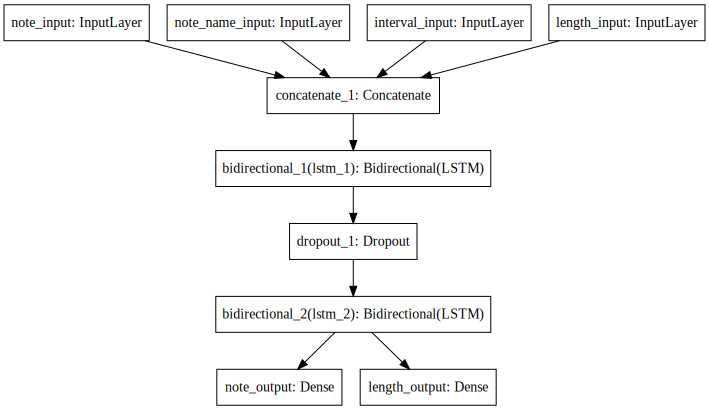

In [13]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.6
	epochs_drop = 25
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [15]:
def listen_callback(epoch, logs):
    if epoch % 100 == 0 and epoch > -1: 
    # if epoch < -2:
        print('----- Generating melody after Epoch: %d' % epoch)
        
        start_index = random.randint(0, 7000)
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            current_note_phrase = notes_corpus[start_index: start_index + n_time_steps]
            current_interval_phrase = interval_corpus[start_index: start_index + n_time_steps]
            current_note_name_phrase = note_name_corpus[start_index: start_index + n_time_steps]
            current_length_phrase = length_corpus[start_index: start_index + n_time_steps]

            phrases = {
                'note_phrase': current_note_phrase, 
                'length_phrase': current_length_phrase,
                'interval_phrase': current_interval_phrase,
                'note_name_phrase': current_note_name_phrase,
            }

            generated_notes = []
            generated_lengths = []
            generated_notes.extend(current_note_phrase)
            generated_lengths.extend(current_length_phrase)

            # model, phrases,categorized_variables, lookup_indicies, n_time_steps, diversity, n_to_generate
            for step in range(40):
                encoded_prediction = make_encoded_prediction(
                    model=model,
                    phrases=phrases,
                    categorized_variables=categorized_variables,
                    lookup_indicies=lookup_indicies,
                    n_time_steps=n_time_steps
                )

                predictions = decode_predictions(
                    encoded_prediction=encoded_prediction,
                    lookup_indicies=lookup_indicies,
                    temperature=diversity
                )

                generated_notes.append(predictions['note_prediction']) 
                generated_lengths.append(predictions['length_prediction']) 


                last = generated_notes[0]
                phrases['note_phrase'] = np.append(phrases['note_phrase'][1:], predictions['note_prediction'])
                phrases['interval_phrase'] = map_midi_to_interval(phrases['note_phrase'], last)
                phrases['note_name_phrase'] = map_midi_to_note_number(phrases['note_phrase'])
                phrases['length_phrase'] = np.append(phrases['length_phrase'][1:], predictions['length_prediction'])

                print
                
            play_generated_phrase(
                generated_notes=generated_notes[10:],
                generated_lengths=generated_lengths[10:],
                player=player)

In [16]:
lrate = LearningRateScheduler(step_decay)

In [17]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(datetime.datetime.now()), histogram_freq=0, write_graph=True)

In [18]:
listen_callback = LambdaCallback(on_epoch_end=listen_callback)

In [ ]:
logger('TRAINING')
model.fit([note_x, note_name_x, interval_x, length_x], [note_y, length_y],
          batch_size=batch_size,
          epochs=1500,
          callbacks=[
              listen_callback,
#               tensorboard,
            ]
          )

          **********************************
            TRAINING
          **********************************
Epoch 1/1500
46592/46607 [============================>.] - ETA: 0s - loss: 5.3087 - note_output_loss: 3.5016 - length_output_loss: 3.6142----- Generating melody after Epoch: 0
----- diversity: 0.5
65.0 | 0.33
62.0 | 0.23
58.0 | 0.28
57.0 | 1.1
62.0 | 0.37
59.0 | 0.14
55.0 | 0.37
54.0 | 0.93
58.0 | 0.37
55.0 | 0.14
51.0 | 0.19
50.0 | 0.56
0 | 1.3
56.0 | 0.33
53.0 | 0.28
48.0 | 1.2
54.0 | 0.32
51.0 | 0.23
47.0 | 0.28
46.0 | 0.88
66 | 0.33
66 | 0.42
65 | 0.23
60 | 0.46
67 | 0.37
65 | 0.7
0 | 0.37
0 | 0.46
58 | 0.19
58 | 0.23
57 | 0.37
0 | 0.51
0 | 0.32
0 | 0.42
60 | 0.46
0 | 0.51
52 | 0.7
60 | 0.37
52 | 0.42
62 | 0.33
58 | 0.46
0 | 0.42
0 | 0.33
0 | 0.28
55 | 0.33
0 | 0.37
0 | 0.37
0 | 0.28
62 | 0.42
54 | 0.28
0 | 0.33
62 | 0.37
58 | 0.42
67 | 0.33
0 | 0.46
63 | 0.46
58 | 0.51
0 | 0.42
60 | 0.51
66 | 0.23
46607/46607 [==============================] - 67s 1ms/step - loss: 5.3085

In [36]:
save_model(model, 'model_2')

Saved model_2.json and model_2.h5 to disk
